In [8]:
import typing
import lzma
import os
import dataclasses
import itertools
import functools
import json
import contextlib
import zipfile
from importlib import reload
from pathlib import Path
from types import MappingProxyType, SimpleNamespace

import cbor2
import attrs
import tqdm.auto
import jax
import jax.numpy as jnp
import etils.epath
from flax import nnx
import optax
import jaxtyping as jt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arc25 import symmetry, tools as arc25_tools, dataset as challenge_dataset
from arc25.symmetry import D4, transform_vector
from arc25 import serialisation
from arc25.dsl.types import Vector, Dir4
from arc25.vision2.symrep import SymDecompBase, SplitSymDecomp, SymDecompDims, standard_rep, RepSpec
from arc25.vision2.fields import FieldDims, CoordinateGrid
from arc25.vision2.linear import SpaceSymmetricLinear, SpaceSymmetricTensor, SymmetryMappingSpec, SymDecompLinear
from arc25.vision2 import fields, attention, encoder, transformer, mae, swiglu, arc_solver
from arc25.training import saving, dataset, mae as mae_trainer, knn_eval, linear_probe, arc_solver as solver_trainer, row_weighted_adam

In [9]:
#os.environ["XLA_FLAGS"]="--xla_force_host_platform_device_count=2"
os.environ["EPATH_USE_TF"] = "false"

In [10]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"
model_dir = data_root / "models"

In [11]:
with zipfile.ZipFile(data_root/"external/arc-prize-2025.zip","r") as zfh:
    with zfh.open("arc-agi_test_challenges.json","r") as fh:
        raw_challenge_data = json.load(fh)
    with zfh.open("sample_submission.json","r") as fh:
        sample_submission = json.load(fh)


In [12]:
main_dataset = await challenge_dataset.Dataset.load_from_json(
    root=data_root/"external/arc-prize-2025.zip",
    challenges="arc-agi_test_challenges.json",
    id="main",
)

In [14]:
max_size = np.r_[0, 0]
datasets = dict(train=[], test=[])
for k, v in main_dataset.challenges.items():
    for typ,dst in datasets.items():
        if typ=="train" and any(iop.input.shape != iop.output.shape for iop in getattr(v,typ)):
            continue
        for i, iop in enumerate(getattr(v,typ)):
            for kk in ["input","output"]:
                if typ=="test" and kk=="output":
                    continue
                img = getattr(iop,kk)
                ex = dataset.ImageExample(
                    challenge=k,
                    example_idx=i,
                    example_type=kk,
                    image=img,
                )
                sh = np.array(img.shape)
                max_size = np.maximum(max_size, sh)
                dst.append(ex)
challenges = frozenset(raw_challenge_data)
challenge_order = tuple(sorted(challenges))
datasets = SimpleNamespace(**{k:dataset.ImagesDataset(
    examples=tuple(v),
    challenges=challenges,
    max_size=tuple(int(v) for v in max_size),
) for k,v in datasets.items()})
print(max_size)

[30 30]


In [16]:
num_solution_attempts = 4

In [17]:
solver = arc_solver.ARCSolver(
    **arc_solver.configs["small"],
    num_latent_programs = len(challenge_order)*num_solution_attempts,
    dtype=jnp.float32,
    rngs=nnx.Rngs(42),
)

In [18]:
import arc25.training.cli

In [19]:
chkp_path = etils.epath.Path(
    "gs://576e2361-arc-agi-2/checkpoints/20251030-1638-vertex-ai-arc-solver-small-4xv6e/"
    "20251030-1638-vertex-ai-arc-solver-small-4xv6e-chkp-000256.msgpack.xz"
)
checkpoint_data = saving.load_model(chkp_path)
solver_checkpoint = checkpoint_data.state.model
del solver_checkpoint["latent_program_embeddings"]
nnx.update(solver, solver_checkpoint)


In [20]:
num_devices = jax.local_device_count()

bucket_cuts = [30]
bucket_shapes = tuple(sorted(set(
   itertools.product(bucket_cuts,bucket_cuts) 
)))


In [21]:

config = solver_trainer.ArcSolverConfig(
    batch_size=128,
    base_cell_cost=0,
    minibatch_size=64 * num_devices,
    eval_batch_size=32 * num_devices // num_solution_attempts,
    learning_rate=1e-3,
    max_num_epochs=24,
    warmup_steps=8,
    checkpoint_every_steps=None,
    eval_every_ref_batch=None,
    num_solution_attempts=num_solution_attempts,

    reference_image_size=15,
    ref_batch=256,
    max_num_ref_batches=None,
    mode="flat",
    remat=True,
    unroll=None,
    
    loss_focus=0,
    loss_focus_eps=0.01,
    loss_focus_limit=float(np.log(10)),
    loss_focus_beta=0.95,
)

In [22]:
input_ds, output_ds = datasets.train.split_input_output()

(training_ds,) = [
    dataset.BucketedDataset.make(
        ds,
        bucket_shapes,
        challenges=challenge_order,
    )
    for ds in [output_ds]
]

# Create collator with proper seed and granularity
minibatch_size_fn = dataset.MinibatchSizeFunction(
    reference_minibatch_size=config.minibatch_size,
    reference_image_size=config.reference_image_size,
    base_cost=config.base_cell_cost,
    granularity=num_devices,  # Ensure divisibility for pmap
)

batch_spec = dataset.BatchSpec(
    target_batch_weight=config.batch_size,
    reference_image_size=config.reference_image_size,
    area_weight_exponent=None,
)

collator = dataset.BucketedCollator.make(
    dataset=training_ds,
    batch_spec=batch_spec,
    minibatch_size=minibatch_size_fn,
    seed=config.seed,  # Tie dataset seed to training seed
)

input_src = dataset.OnDemandBucketDataset(
    input_ds,
    bucket_shapes=bucket_shapes,
    challenges=challenge_order,
    weight_fun=lambda area: None,
)

In [23]:
class STrainState(solver_trainer.TrainState):
    """Training state for ArcSolver with encoder-decoder architecture.

    The encoder is frozen (stop_gradient applied), only decoder is trained.
    """

    train_filter: typing.ClassVar = nnx.filterlib.All(
        nnx.Param, nnx.PathContains("latent_program_embeddings")
    )

In [24]:
rngs = nnx.Rngs(199)
trainer = solver_trainer.ArcSolverTrainer.make(
    config=config,
    model=solver,
    collator=collator,
    inputs_src=input_src,
    num_devices=num_devices,
    rngs=rngs,
    eval_dataset=None,
    with_progress_bars=True,
)

In [25]:
trainer.train_state = train_state = STrainState.make(solver, config, rngs=rngs)

In [36]:
import pandas as pd

res = trainer.run_main()
hist = pd.DataFrame([r for r in res])

--- ArcSolverTrainer ---
Run: 20251101-1215-ArcSolverTrainer
Devices: 1 × cpu
Training batch data weight: 128 (1 optimizer step)
Reference step data weight: 256 (~2.00 optimizer steps)
Total steps: 97
Evaluation: every None reference steps
----------------------------

Starting training...


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Tracing _compute_grads for shape dict(cell_weight=(16,30,30), input_sizes=(16,2), inputs=(16,30,30), latent_program_idx=(16), output_masks=(16,30,30), outputs=(16,30,30)) (kw=dict(mode='flat', remat=True, unroll=None))
Tracing _compute_grads for shape dict(cell_weight=(16,30,30), input_sizes=(16,2), inputs=(16,30,30), latent_program_idx=(16), output_masks=(16,30,30), outputs=(16,30,30)) (kw=dict(mode='flat', remat=True, unroll=None))
Tracing _apply_update
Tracing _compute_grads for shape dict(cell_weight=(16,30,30), input_sizes=(16,2), inputs=(16,30,30), latent_program_idx=(16), output_masks=(16,30,30), outputs=(16,30,30)) (kw=dict(mode='flat', remat=True, unroll=None))
Tracing _apply_update

Training interrupted by user

--- Training Finished ---
Total time: 10591.6s
Average throughput: 0.5 weight/s


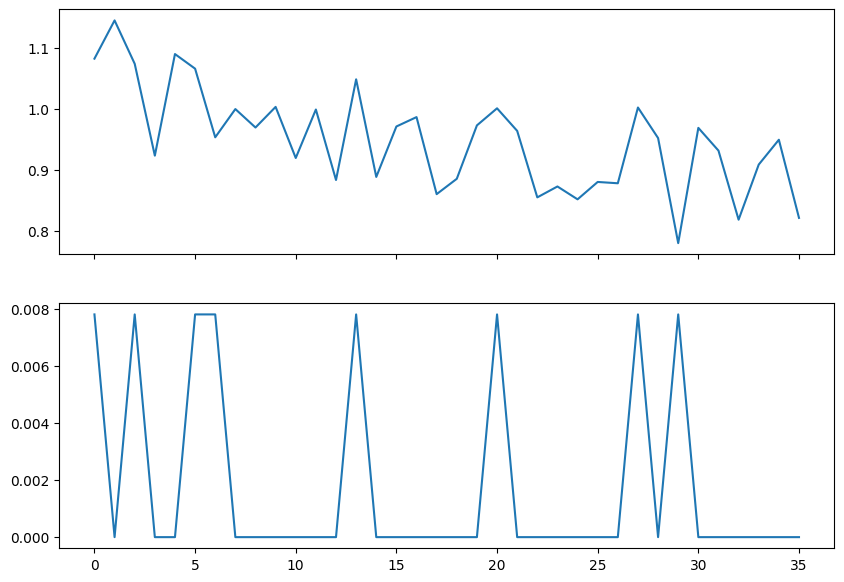

In [38]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(2,1,figsize=(10,7),sharex=True)
for ax,v in zip(axes,[hist.pair_crossentropy, hist.pair_accuracy]):
    ax.plot(hist.index, v)

In [39]:
import squarify
import matplotlib as mpl

def show_prediction(prediction: jt.Float[jt.Array,"Y X C"], *, ground_truth: dataset.Image | None = None, ax=None, pad=0.05, **kw):
    if ax is None:
        ax = plt.gca()
    match ground_truth:
        case np.ndarray() | None:
            pass
        case dataset.Image():
            ground_truth = ground_truth._data
        case dataset.MaskedImage():
            ground_truth = np.where(ground_truth._mask, ground_truth._data, np.nan)
        case _:
            raise TypeError(f"Unsupported image type {type(ground_truth).__qualname__}")
        
    p = np.array(prediction)
    p *= 1/p.sum(axis=-1,keepdims=True)
    
    if False:
        # plot base mesh
        img = np.tile(np.nan,p.shape[:-1])
        # just for the mesh
        ax.pcolormesh(
            img,
            ec="gray",
            lw=0.4,
            **kw,
        )

    seq = np.argsort(p,axis=-1)[...,::-1]
    sorted_p = np.take_along_axis(p,seq,axis=-1)
    rects = [[] for _ in range(10)]
    first = [[] for _ in range(10)]
    s = 1-2*pad
    clist = tuple(c.value for c in arc25_tools.Color)
    for idx in np.ndindex(p.shape[:2]):
        y,x = idx
        a = sorted_p[idx]
        assert np.all(a[1:] <= a[:-1]), str(np.round(a*100).astype(int))
        cell = squarify.squarify(
            a*s**2,
            x+pad,y+pad,s,s,
        )
        for j,(i,r) in enumerate(zip(seq[idx],cell)):
            (rects[i] if j else first[i]).append(mpl.patches.Rectangle((r["x"],r["y"]),r["dx"],r["dy"]))
    for rss,a in zip([rects,first],[0.5,1]):
        for rs,c in zip(rss, clist):
            coll = mpl.collections.PatchCollection(rs,fc=c,ec="none",lw=0.2,alpha=a)
            ax.add_collection(coll)

    h,w = p.shape[:2]
    ax.set_xlim(0,w)
    ax.set_ylim(0,h)
    ax.yaxis.set_inverted(True)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect("equal", "box")
    return ax


In [61]:
M = num_solution_attempts
results = {}
for k,v in tqdm.auto.tqdm(list(main_dataset.challenges.items())[:20]):
    trip = list(v.get_empty_eval_triples())
    N = len(trip)
    Nt = len(v.train)
    inputs = np.zeros((N,M,30,30),"i1")
    shapes = np.zeros((N,M,2),int)
    outputs = np.zeros((Nt,M,30,30),"i1")
    output_masks = np.zeros((Nt,M,30,30),bool)
    for i,img in enumerate(trip):
        h,w = img.input.shape
        inputs[i,:,:h,:w] = img.input._data
        shapes[i,:,:] = [h,w]
        if img.expected is not None:
            h,w = img.expected.shape
            outputs[i,:,:h,:w] = img.expected._data
            output_masks[i,:,:h,:w] = True
    idx = np.tile(challenge_order.index(k),(N,M))

    logits = solver(
        inputs,
        shapes,
        latent_program_idx=idx,
        deterministic=True,
        mode="flat",
    )

    # Loss on ALL output cells (not masked like MAE)
    cell_crossentropy = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits[:Nt], labels=outputs, axis=-1
    )

    cell_weights = output_masks/np.prod(shapes[:Nt],axis=-1)[...,None,None]
    # Mask to valid output regions and weight by pre-normalized cell weights
    pair_crossentropy = jnp.where(
        output_masks, cell_crossentropy * cell_weights, 0
    ).sum(axis=(-2, -1)).mean(0)

    # Per-cell accuracy
    predictions = jnp.argmax(logits, axis=-1)
    cell_correct = predictions[:Nt] == outputs
    cell_accuracy = (
        jnp.where(cell_correct & output_masks, cell_weights, 0)
        .astype(jnp.float32)
        .sum(axis=(-2, -1))
    ).mean(0)

    # Per-pair accuracy (all cells in output must be correct)
    pair_accuracy = (
        (
            # Padding doesn't count against accuracy
            cell_correct
            | ~output_masks
        )
        .all(axis=(-2, -1))
        .astype(jnp.float32)
    ).mean(0)

    results[k] = SimpleNamespace(
        challenge = v,
        **{kk:np.asarray(vv) for kk,vv in dict(
            logits = logits,
            predictions = predictions,
            pair_accuracy = pair_accuracy,
            pair_crossentropy = pair_crossentropy,
            cell_accuracy = cell_accuracy,
        ).items()}
    )


  0%|          | 0/20 [00:00<?, ?it/s]

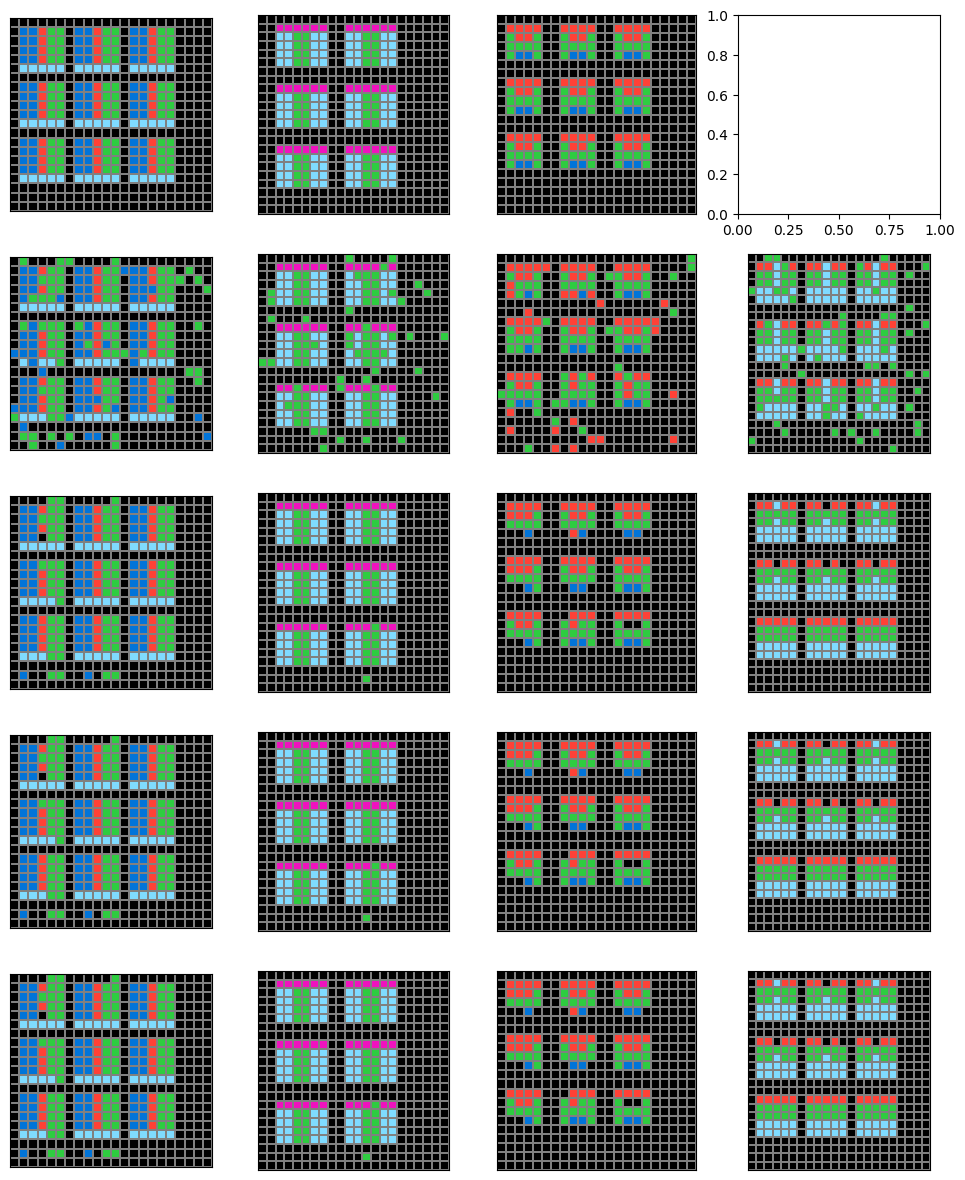

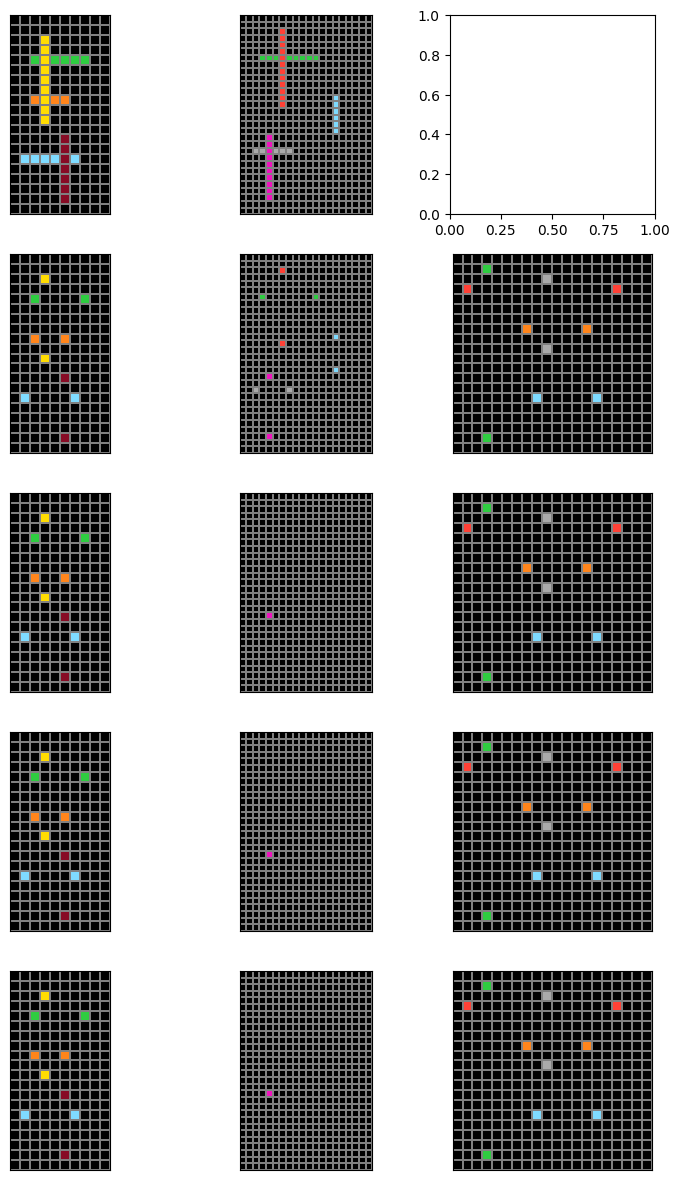

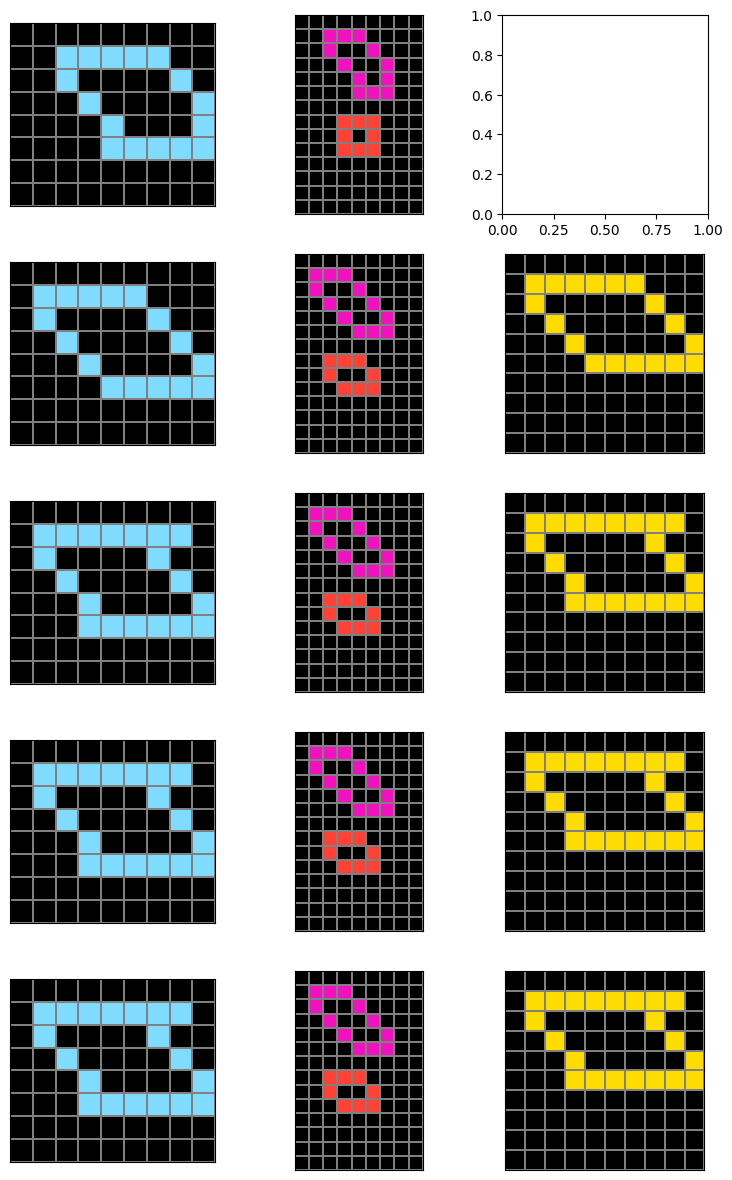

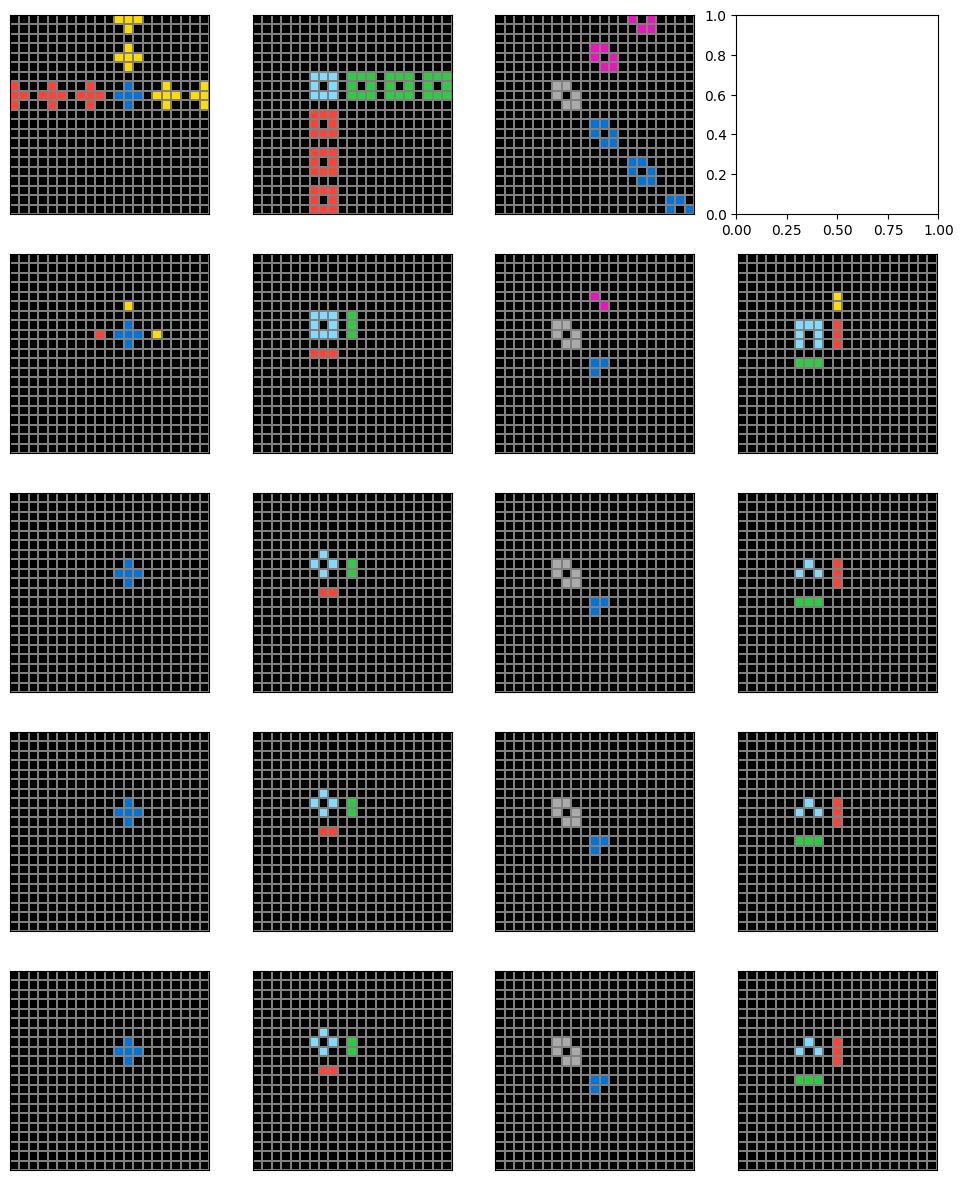

In [66]:
preds = sorted(results.values(),key=lambda p:p.pair_crossentropy.min())[:4]

M = 3+2
for pred in preds:
    N = pred.logits.shape[0]
    idx = np.argsort(pred.pair_crossentropy)[:M-2]
    s = 3
    fig, axes = plt.subplots(M,N,figsize=(N*s,M*s))
    
    for trip,log,axe in zip(pred.challenge.get_empty_eval_triples(),pred.logits,axes.T):
        ax = axe[1]
        arc25_tools.show_image(trip.input,ax=ax)
        if trip.expected is not None:
            ax = axe[0]
            arc25_tools.show_image(trip.expected,ax=ax)
        # this should be the predicted output shape, but we don't predict that,
        # so we have to live with the input shape
        h,w = trip.input.shape
        for ax,lg in zip(axe[2:],log[idx]):
            if False:
                show_prediction(jax.nn.softmax(lg[:h,:w,:],axis=-1),ax=ax)
            else:
                arc25_tools.show_image(np.argmax(lg[:h,:w,:],axis=-1),ax=ax)

In [83]:
submission = {}
for pred in results.values():
    Nt = len(pred.challenge.test)
    solutions = [{} for _ in range(Nt)]
    seen = set()
    attempt = 0
    # iterate over candidate solutions in order of increasing cross-entropy on the test set
    for k,i in enumerate(np.argsort(pred.pair_crossentropy)):
        sols = []
        for ex,logits in zip(pred.challenge.test,pred.logits[-Nt:,i]):
            h,w = ex.input.shape
            sol = tuple(tuple(int(v) for v in row) for row in np.argmax(lg[:h,:w,:],axis=-1))
            sols.append(sol)
        sols = tuple(sols)
        if sols in seen and num_solution_attempts-k > 2-len(seen) :
            continue
        seen.add(sols)
        attempt += 1
        for dst,src in zip(solutions, sols):
            dst[f"attempt_{attempt}"] = src
    assert all(len(d)==2 for d in solutions)
    submission[pred.challenge.id] = solutions


{"00576224": [{"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]}], "007bbfb7": [{"attempt_1": [[0, 0, 0], [0, 0, 0], [0, 0, 0]], "attempt_2": [[0, 0, 0], [0, 0, 0], [0, 0, 0]]}], "009d5c81": [{"attempt_1": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "attempt_2": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0,

## Direct

In [11]:
config = solver_trainer.ArcSolverConfig(
    max_num_epochs = None,
    max_num_ref_batches = 1,
    eval_batch_size=64,
)

trainer = solver_trainer.ArcSolverTrainer.make(
    config=config,
    model=solver,
    collator=None,
    inputs_src=SimpleNamespace(challenges=challenge_order, bucket_shapes=bucket_shapes),
    num_devices=num_devices,
    rngs=None,#nnx.Rngs(config.seed),
#    lr_schedule=lr_schedule,
    eval_dataset=datasets.train,
    with_progress_bars=True,
)

In [12]:
trainer._cache_embeddings()

  0%|          | 0/12 [00:00<?, ?it/s]

Tracing embed_inputs for shape dict(input_sizes=(1,7,2), inputs=(1,7,12,12)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing embed_inputs for shape dict(input_sizes=(1,64,2), inputs=(1,64,12,12)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing embed_inputs for shape dict(input_sizes=(1,39,2), inputs=(1,39,12,20)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing embed_inputs for shape dict(input_sizes=(1,8,2), inputs=(1,8,12,30)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing embed_inputs for shape dict(input_sizes=(1,22,2), inputs=(1,22,20,20)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing embed_inputs for shape dict(input_sizes=(1,64,2), inputs=(1,64,20,20)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing embed_inputs for shape dict(input_sizes=(1,12,2), inputs=(1,12,20,30)) (kw=dict(mode='flat', remat=True, unroll=No

In [13]:
def loss_fn(model, minibatch):
    nsa = num_solution_attempts

    mbd = jax.tree.map(
        lambda a: jnp.tile(a[:, None, ...], (1, nsa) + (1,) * (a.ndim - 1)),
        minibatch,
    )

    embeddings = mbd["embeddings"]
    output_sizes = mbd["output_sizes"]
    latent_program_idx = mbd["latent_program_idx"] * nsa
    latent_program_idx += np.arange(nsa)[
        None, :, *(None,) * (latent_program_idx.ndim - 2)
    ]

    logits = model.decode(
        embeddings,
        output_size=output_sizes,
        latent_program_idx=latent_program_idx,
        mode="flat",
        remat=True,
        unroll=None,
        deterministic=True,
    ).astype(jnp.float32)
            
    outputs = mbd["outputs"]
    output_masks = mbd["output_masks"]
    cell_weights = mbd["cell_weight"]

    # Loss on ALL output cells (not masked like MAE)
    cell_crossentropy = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=outputs, axis=-1
    )

    # Mask to valid output regions and weight by pre-normalized cell weights
    pair_crossentropy = jnp.where(
        output_masks, cell_crossentropy * cell_weights, 0
    ).sum(axis=(-2, -1))
    loss = pair_crossentropy.sum()

    # Per-cell accuracy
    predictions = jnp.argmax(logits, axis=-1)
    cell_correct = predictions == outputs
    cell_accuracy = (
        jnp.where(cell_correct & output_masks, cell_weights, 0)
        .astype(jnp.float32)
        .sum(axis=(-2, -1))
    )

    # Per-pair accuracy (all cells in output must be correct)
    pair_accuracy = (
        (
            # Padding doesn't count against accuracy
            cell_correct
            | ~output_masks
        )
        .all(axis=(-2, -1))
        .astype(jnp.float32)
    )
 

    stats = dict(
        pair_crossentropy = pair_crossentropy,
        cell_accuracy = cell_accuracy,
        pair_accuracy = pair_accuracy,        
    )

    pcs = {k[5:]:v for k,v in stats.items() if k.startswith("pair_")}
    per_example_stats = jnp.stack(list(pcs.values()), axis=-1)

    K = model.latent_program_embeddings.shape[0]
    N = per_example_stats.shape[-1]
    per_task = (
        jnp.zeros((K, N), dtype=per_example_stats.dtype)
        .at[latent_program_idx]
        .add(per_example_stats)
    ).reshape(-1, nsa, N)

    stats = {k: v.sum() for k, v in stats.items()} | dict(
        per_task={k: per_task[..., i] for i, k in enumerate(pcs)},
    )
    
    return loss, stats

In [14]:
train_filter = nnx.PathContains("latent_program_embeddings")

@nnx.jit
def train_step(model, minibatch):
    grad_fn = nnx.value_and_grad(
        loss_fn,
        argnums=nnx.DiffState(0, train_filter),
        has_aux=True,
    )
    (_, stats), grads = grad_fn(model, minibatch)
    return grads, stats


In [15]:
def accumulate_grads(trainer):
    self = trainer
    eval_data = self._eval_data_cache

    mesh = jax.make_mesh(
        (self.num_devices,),
        ("batch",),
        axis_types=(jax.sharding.AxisType.Auto,),
    )

    def reshard(a, *args):
        return jax.device_put(
            a,
            jax.NamedSharding(mesh, jax.sharding.PartitionSpec(*args)),
        )

    model_graph, model_state = nnx.split(self.train_state.model)
    model_state = jax.tree.map(lambda a: reshard(a), model_state)
    resharded_model = nnx.merge(model_graph, model_state)

    res = None
    with contextlib.ExitStack() as stack:
        stack.enter_context(jax.set_mesh(mesh))
        if self.with_progress_bars:
            import tqdm.auto

            pbar = stack.enter_context(
                tqdm.auto.tqdm(total=len(eval_data.minibatches), leave=False)
            )
        else:
            pbar = None

        for minibatch in eval_data.minibatches:
            step_res = train_step(
                resharded_model,
                minibatch,
            )
            if res is None:
                res = step_res
            else:
                res = jax.tree.map(lambda a, b: a + b, res, step_res)

            if pbar is not None:
                pbar.update()

    grads, stats = res

    per_task = stats.pop("per_task")
    shape = (resharded_model.latent_program_embeddings.shape[0]//num_solution_attempts, num_solution_attemtps)
    per_task = {
        k: np.asarray(v)
        / np.maximum(1, eval_data.per_class_total_weight).reshape(*shape)
        for k, v in per_task.items()
    }
    stats = {k: float(v) / max(1, eval_data.total_weight) for k, v in res.items()}
    stats.update({
        f"best_{k}":v.max(1).mean()
        for k,v in per_task.items()
    })
    return grads, stats

In [21]:
t = train_step.trace(trainer.train_state.model, trainer._eval_data_cache.minibatches[0])
cost = t.lower().compile().cost_analysis()
cost

{'utilization431{}': 1.0,
 'utilization196{}': 3.0,
 'bytes accessedout{0}': 64512.0,
 'utilization615{}': 1.0,
 'utilization281{}': 3.0,
 'utilization19{}': 6.0,
 'utilization406{}': 3.0,
 'utilization364{}': 3.0,
 'utilization256{}': 3.0,
 'utilization222{}': 3.0,
 'utilization514{}': 1.0,
 'utilization180{}': 5.0,
 'utilization229{}': 3.0,
 'utilization86{}': 5.0,
 'utilization330{}': 3.0,
 'utilization651{}': 1.0,
 'utilization125{}': 5.0,
 'utilization128{}': 5.0,
 'utilization476{}': 1.0,
 'utilization449{}': 1.0,
 'utilization292{}': 3.0,
 'utilization626{}': 1.0,
 'utilization584{}': 1.0,
 'utilization299{}': 3.0,
 'utilization550{}': 1.0,
 'utilization442{}': 1.0,
 'utilization72{}': 5.0,
 'utilization45{}': 5.0,
 'utilization195{}': 3.0,
 'utilization198{}': 3.0,
 'utilization345{}': 3.0,
 'utilization237{}': 3.0,
 'utilization348{}': 3.0,
 'utilization203{}': 3.0,
 'utilization161{}': 5.0,
 'utilization311{}': 3.0,
 'bytes accessed13{}': 33098272.0,
 'utilization31{}': 5.0,


In [16]:
tx = optax.adam(1e-2,b1=0.9,b2=0.99)
optimizer = nnx.Optimizer(
    trainer.train_state.model,
    tx,
    wrt=train_filter,
)

for step in (pbar:=tqdm.auto.trange(0)):
    grads,stats = accumulate_grads(trainer)
    optimizer.update(trainer.train_state.model, grads)
    print(stats)
    asdfasd

0it [00:00, ?it/s]